C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading test data from Hugging Face Cache...
Loaded 196 class names.
Loading Model from resnet50_stanford_cars_new.pth...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21360\1454602126.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Running Inference on 8041 images...

      TEST RESULTS       
Overall Accuracy: 82.78%

Generating Detailed Report...

--- Top 5 Best Classified Cars ---
                                       precision    recall  f1-score  support
Chrysler PT Cruiser Convertible 2008    1.000000  0.977778  0.988764     45.0
Dodge Challenger SRT8 2011              0.974359  0.974359  0.974359     39.0
MINI Cooper Roadster Convertible 2012   1.000000  0.944444  0.971429     36.0
Volvo 240 Sedan 1993                    0.977273  0.955556  0.966292     45.0
Dodge Caravan Minivan 1997              0.954545  0.976744  0.965517     43.0

--- Top 5 Worst Classified Cars ---
                                   precision    recall  f1-score  support
Chevrolet Express Cargo Van 2007    0.166667  0.034483  0.057143     29.0
Bentley Continental GT Coupe 2012   0.700000  0.205882  0.318182     34.0
Audi TTS Coupe 2012                 0.681818  0.357143  0.468750     42.0
Chevrolet Express Van 2007          0.473684

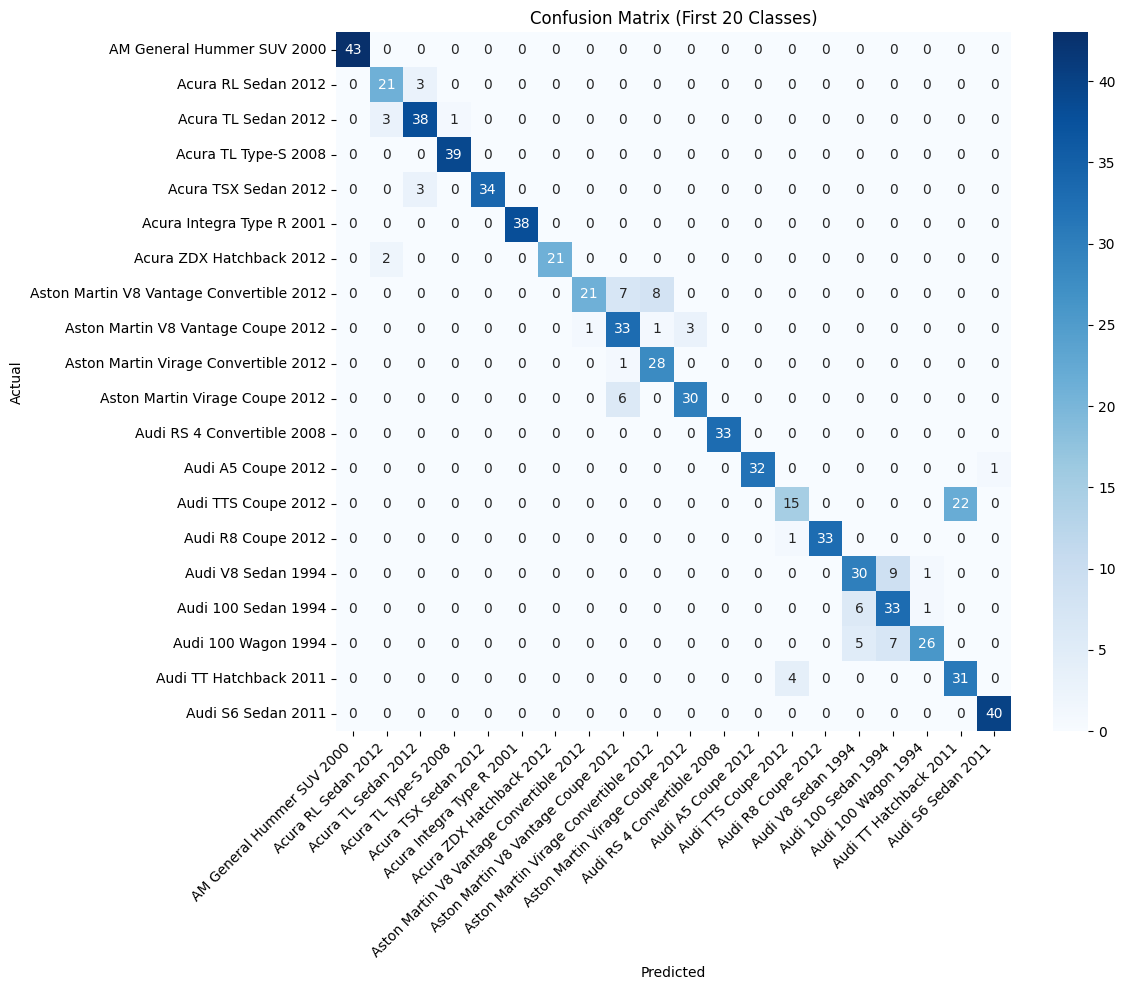

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from datasets import load_dataset
from model_utils import get_transforms

# ==========================================
# 1. CONFIGURATION
# ==========================================
MODEL_PATH = "resnet50_stanford_cars_new.pth"
BATCH_SIZE = 32
NUM_CLASSES = 196

# ==========================================
# 2. DATASET WRAPPER
# ==========================================
class HuggingFaceCarDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        # Convert to RGB (Crucial: fixes grayscale errors in Stanford dataset)
        image = item['image'].convert('RGB')
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
        return image, label

# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
def get_resnet_model(num_classes=196):
    model = models.resnet50(weights=None) 
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model

# ==========================================
# 4. EVALUATION LOGIC
# ==========================================
def evaluate_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- 1. LOAD DATA (AUTOMATIC FROM CACHE) ---
    print("Loading test data from Hugging Face Cache...")
    
    # This will instantly find the files you already downloaded!
    hf_dataset = load_dataset("tanganke/stanford_cars")

    # Get the actual class names (e.g., 'Acura Integra...')
    class_names = hf_dataset['train'].features['label'].names
    print(f"Loaded {len(class_names)} class names.")

    # Prepare Test Loader
    tfms = get_transforms(img_size=(224, 224))
    # Note: We use the 'test' split for evaluation
    test_ds = HuggingFaceCarDataset(hf_dataset['test'], transform=tfms['val'])
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # --- 2. LOAD MODEL ---
    print(f"Loading Model from {MODEL_PATH}...")
    model = get_resnet_model(num_classes=NUM_CLASSES)
    
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file '{MODEL_PATH}' not found. Make sure you trained it first!")
        return

    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    model.to(device)
    model.eval()

    # --- 3. INFERENCE LOOP ---
    print(f"Running Inference on {len(test_ds)} images...")
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # --- 4. METRICS & VISUALIZATION ---
    print("\n" + "="*30)
    print("      TEST RESULTS       ")
    print("="*30)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {acc*100:.2f}%")

    # Classification Report
    print("\nGenerating Detailed Report...")
    report_dict = classification_report(
        all_labels, 
        all_preds, 
        target_names=class_names, 
        output_dict=True, 
        zero_division=0
    )
    report_df = pd.DataFrame(report_dict).transpose()
    
    print("\n--- Top 5 Best Classified Cars ---")
    print(report_df.sort_values(by='f1-score', ascending=False).head(5)[['precision', 'recall', 'f1-score', 'support']])

    print("\n--- Top 5 Worst Classified Cars ---")
    classes_only = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    print(classes_only.sort_values(by='f1-score', ascending=True).head(5)[['precision', 'recall', 'f1-score', 'support']])

    # Confusion Matrix
    print("\nGenerating Confusion Matrix (First 20 classes)...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names[:20], yticklabels=class_names[:20])
    plt.title("Confusion Matrix (First 20 Classes)")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_model()

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading test data from Hugging Face Cache...
Loaded 196 class names.
Loading Model from resnet50_new_hugg_preproce.pth...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2472\2969448075.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=d

Running Inference on 8041 images...

      TEST RESULTS       
Overall Accuracy: 85.72%

Generating Detailed Report...

--- Top 5 Best Classified Cars ---
                                      precision    recall  f1-score  support
Dodge Magnum Wagon 2008                1.000000  0.975000  0.987342     40.0
FIAT 500 Abarth 2012                   0.964286  1.000000  0.981818     27.0
Chrysler PT Cruiser Convertible 2008   0.957447  1.000000  0.978261     45.0
Chrysler Crossfire Convertible 2008    0.976744  0.976744  0.976744     43.0
Dodge Durango SUV 2012                 0.976744  0.976744  0.976744     43.0

--- Top 5 Worst Classified Cars ---
                                            precision    recall  f1-score  \
Chevrolet Express Cargo Van 2007             0.400000  0.206897  0.272727   
Chevrolet Express Van 2007                   0.485714  0.485714  0.485714   
Audi S5 Coupe 2012                           0.512195  0.500000  0.506024   
Chevrolet Silverado 1500 Extended Cab 

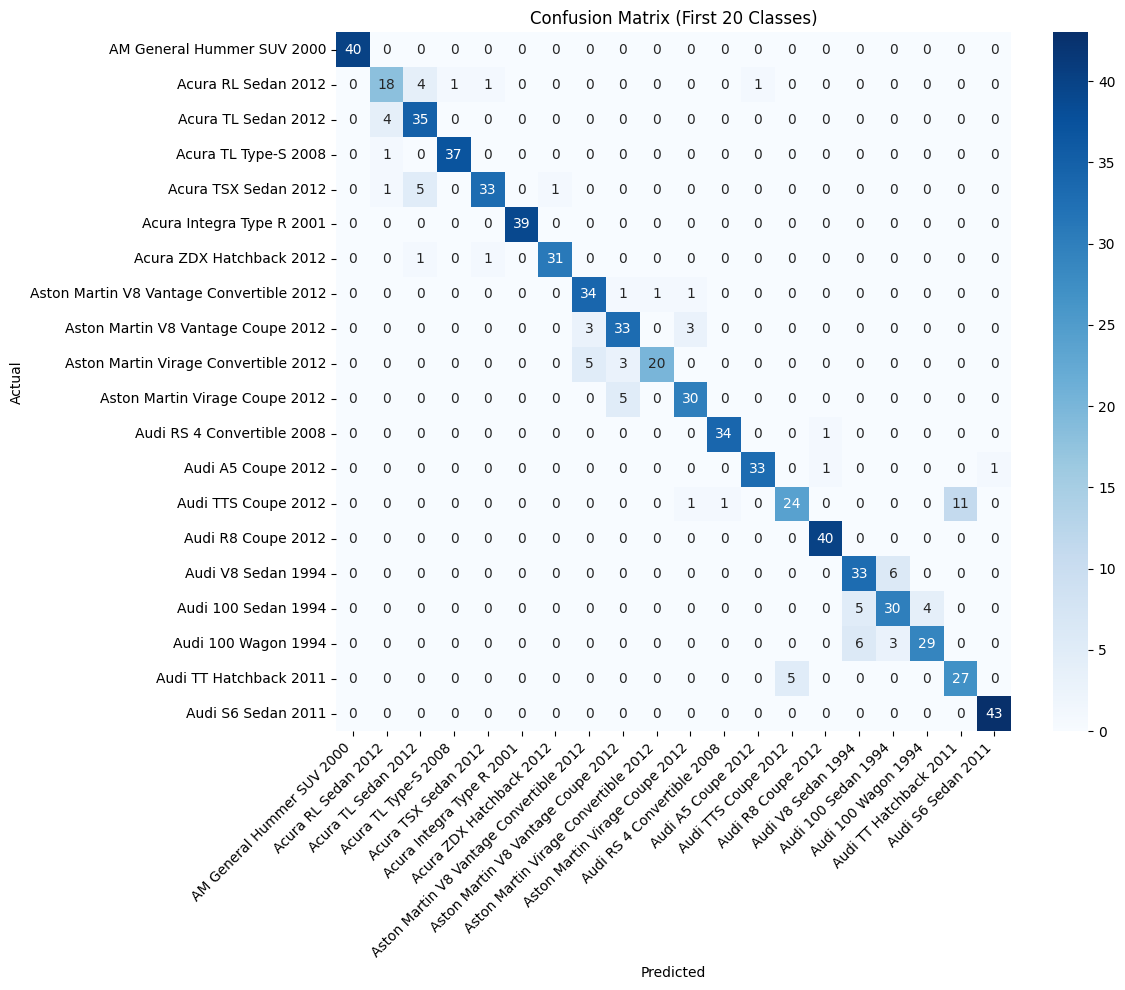

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from datasets import load_dataset
from model_utils import get_transforms

# ==========================================
# 1. CONFIGURATION
# ==========================================
MODEL_PATH = "resnet50_new_hugg_preproce.pth"
BATCH_SIZE = 32
NUM_CLASSES = 196

# ==========================================
# 2. DATASET WRAPPER
# ==========================================
class HuggingFaceCarDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        # Convert to RGB (Crucial: fixes grayscale errors in Stanford dataset)
        image = item['image'].convert('RGB')
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
        return image, label

# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
def get_resnet_model(num_classes=196):
    model = models.resnet50(weights=None) 
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )
    return model

# ==========================================
# 4. EVALUATION LOGIC
# ==========================================
def evaluate_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- 1. LOAD DATA (AUTOMATIC FROM CACHE) ---
    print("Loading test data from Hugging Face Cache...")
    
    # This will instantly find the files you already downloaded!
    hf_dataset = load_dataset("tanganke/stanford_cars")

    # Get the actual class names (e.g., 'Acura Integra...')
    class_names = hf_dataset['train'].features['label'].names
    print(f"Loaded {len(class_names)} class names.")

    # Prepare Test Loader
    tfms = get_transforms(img_size=(224, 224))
    # Note: We use the 'test' split for evaluation
    test_ds = HuggingFaceCarDataset(hf_dataset['test'], transform=tfms['val'])
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # --- 2. LOAD MODEL ---
    print(f"Loading Model from {MODEL_PATH}...")
    model = get_resnet_model(num_classes=NUM_CLASSES)
    
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file '{MODEL_PATH}' not found. Make sure you trained it first!")
        return

    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    model.to(device)
    model.eval()

    # --- 3. INFERENCE LOOP ---
    print(f"Running Inference on {len(test_ds)} images...")
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_dl:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # --- 4. METRICS & VISUALIZATION ---
    print("\n" + "="*30)
    print("      TEST RESULTS       ")
    print("="*30)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {acc*100:.2f}%")

    # Classification Report
    print("\nGenerating Detailed Report...")
    report_dict = classification_report(
        all_labels, 
        all_preds, 
        target_names=class_names, 
        output_dict=True, 
        zero_division=0
    )
    report_df = pd.DataFrame(report_dict).transpose()
    
    print("\n--- Top 5 Best Classified Cars ---")
    print(report_df.sort_values(by='f1-score', ascending=False).head(5)[['precision', 'recall', 'f1-score', 'support']])

    print("\n--- Top 5 Worst Classified Cars ---")
    classes_only = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    print(classes_only.sort_values(by='f1-score', ascending=True).head(5)[['precision', 'recall', 'f1-score', 'support']])

    # Confusion Matrix
    print("\nGenerating Confusion Matrix (First 20 classes)...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names[:20], yticklabels=class_names[:20])
    plt.title("Confusion Matrix (First 20 Classes)")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_model()